In [2]:
from sqlalchemy import Column, Integer, MetaData, Table, create_engine, String
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.orm import sessionmaker
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.sql import select
from sqlalchemy import func

In [3]:
engine = create_engine('postgres://douglas@postgis:5432/AQI', client_encoding='utf8')
Session = sessionmaker(bind=engine)
session = Session()

metadata = MetaData()
metadata.reflect(engine, only=['locs_airlocation', 'locs_airmeasurement'])
Base = automap_base(metadata=metadata)
Base.prepare()

AirLocation, AirMeasurement = Base.classes.locs_airlocation, Base.classes.locs_airmeasurement

/opt/conda/lib/python3.5/site-packages/sqlalchemy/dialects/postgresql/base.py:2503: SAWarning: Did not recognize type 'geometry' of column 'coordinates'
  (attype, name))


In [4]:
# Select some airlocation with bad aqi
s = select([AirLocation]).where(AirLocation.aqi > 100)
some_airlocation_id = session.execute(s).scalar()
s = select([AirLocation]).where(AirLocation.id == some_airlocation_id)
some_airlocation = session.execute(s).first()
print("{}, {}".format(some_airlocation.short_name, some_airlocation.en_country_name))
s = select([func.count(AirMeasurement.id)]).where(
    AirMeasurement.airlocation_id == some_airlocation_id
).where(
    AirMeasurement.aqi != None
).where(
    AirMeasurement.aqi != 0
)
some_airlocation_measurement_count = session.execute(s).first()[0]
print("{} AQI measurements for this city".format(some_airlocation_measurement_count))

Mudanjiang, China
37663 AQI measurements for this city


In [5]:
# Collect the measurements for that AirLocation into a
# numpy array like [(min of day, day of year, day of week, day of month, aqi)]
s = select([AirMeasurement.id, AirMeasurement.measurement_datetime, AirMeasurement.aqi]).where(
    AirMeasurement.airlocation_id == some_airlocation_id
).where(
    AirMeasurement.aqi != None
).where(
    AirMeasurement.aqi != 0
).order_by(AirMeasurement.id.asc())

import numpy as np
import pandas as pd
measurements = pd.read_sql(s, engine)

In [6]:
import math
import itertools


def make_circular_input(input, input_max, input_min=0):
    '''
    Convert the input to a circular input between 0-1.
    Circular input being two values which cause the smallest and
    largest values inputted to this function appear to be beside each other.
    
    This is used, for example, to make the last minute of the day "close" to
    the first minute of the day.
    '''
    # normalize the input to a real 0-1, then project it along
    # the first period of the sine/cosine waves
    normalized_projected = 2 * math.pi * (input - input_min) / (input_max - input_min)
    
    # apply sine / cosine and convert to a real number 0-1
    sine = (1 + math.sin(normalized_projected)) / 2
    cosine = (1 + math.cos(normalized_projected)) / 2
    assert 1 >= sine >= 0
    assert 1 >= cosine >= 0
    return sine, cosine


def get_normalized_time_inputs(dt):
    return tuple(itertools.chain(
        # minute of day
        make_circular_input((dt.time().hour * 60) + dt.time().minute, 1440),
        # day of the year 
        make_circular_input(dt.timetuple().tm_yday, 365),
        # day of the week, from 0 to 6
        make_circular_input(dt.date().weekday(), 6),
        # day of the month
        make_circular_input(dt.date().day, 31, 1),
    ))

measurements['minute_of_day_sin'], measurements['minute_of_day_cos'], \
measurements['day_of_year_sin'], measurements['day_of_year_cos'], \
measurements['day_of_week_sin'], measurements['day_of_week_cos'], \
measurements['day_of_month_sin'], measurements['day_of_month_cos'] = \
    zip(*measurements["measurement_datetime"].map(get_normalized_time_inputs))

# This is a common AQI ceiling for prediction/presentation, and appropriate for this city.
MAX_AQI = 300
def get_normalized_aqi(aqi):
    if not aqi:
        return 0
    return min(aqi, MAX_AQI) / 300

def get_denormalized_aqi(normalized_aqi):
    try:
        if normalized_aqi is None or normalized_aqi <= 0:
            return 0
        return round(normalized_aqi * 300)
    except Exception:
        return 0

measurements['normalized_aqi'] = measurements['aqi'].map(get_normalized_aqi)

In [7]:
# Generate the baseline predictions
# (The prediction is the previous AQI measurement)
measurements['baseline_pred_aqi'] = measurements.aqi.shift(1)

In [8]:
# Perform test-train split
from sklearn.cross_validation import train_test_split
import itertools
feature_columns = [
    'minute_of_day_sin', 'minute_of_day_cos', 
    'day_of_year_sin', 'day_of_year_cos',  
    'day_of_week_sin', 'day_of_week_cos', 
    'day_of_month_sin', 'day_of_month_cos',
]
# keep the id and baseline through the split to graph results later
x_all = measurements[list(itertools.chain(feature_columns, ['id', 'baseline_pred_aqi', 'aqi']))]
y_all = measurements['normalized_aqi']
y_all.columns = ['actual_aqi']
num_train = int(some_airlocation_measurement_count * 0.85)
# interpolation test-train split - random test points over the whole data set
x_train_i, x_test_i, y_train_i, y_test_i = train_test_split(x_all, y_all, train_size=num_train)
# extrapolation test-train split - test set is the last 25% of the data
x_train_e = x_all[:num_train]
x_test_e = x_all[num_train:]
y_train_e = y_all[:num_train] 
y_test_e = y_all[num_train:]

In [9]:
# Input to SVM model
import time

def train_classifier(clf, x_train, y_train):
    print("Training {}...".format(clf.__class__.__name__))
    start = time.time()
    clf.fit(x_train[feature_columns], y_train)
    end = time.time()
    print("Done!\nTraining time (secs): {:.3f}".format(end - start))

from sklearn import svm
from sklearn import linear_model
#clf = svm.SVR()
clf_i = linear_model.LinearRegression()
train_classifier(clf_i, x_train_i, list(y_train_i.values))

clf_e = linear_model.LinearRegression()
train_classifier(clf_e, x_train_e, list(y_train_e.values))

Training LinearRegression...
Done!
Training time (secs): 0.012
Training LinearRegression...
Done!
Training time (secs): 0.012


In [10]:
def predict_labels(clf, features, target):
    print("Predicting labels using {}...".format(clf.__class__.__name__))
    start = time.time()
    y_pred = clf.predict(features[feature_columns])
    end = time.time()
    print("Done!\nPrediction time (secs): {:.3f}".format(end - start))
    return y_pred

print("Making training predictions...")
y_train_pred_i = predict_labels(clf_i, x_train_i, y_train_i)
y_train_pred_e = predict_labels(clf_e, x_train_e, y_train_e)
print("Making test predictions...")
y_test_pred_i = predict_labels(clf_i, x_test_i, y_test_i)
y_test_pred_e = predict_labels(clf_e, x_test_e, y_test_e)

Making training predictions...
Predicting labels using LinearRegression...
Done!
Prediction time (secs): 0.002
Predicting labels using LinearRegression...
Done!
Prediction time (secs): 0.002
Making test predictions...
Predicting labels using LinearRegression...
Done!
Prediction time (secs): 0.001
Predicting labels using LinearRegression...
Done!
Prediction time (secs): 0.002


In [11]:
from sklearn.metrics import mean_squared_error

# Score predictions
print("Mean squared error for training set (interpolation): {}".format(mean_squared_error(y_train_i, y_train_pred_i)))
print("Mean squared error for training set (extrapolation): {}".format(mean_squared_error(y_train_e, y_train_pred_e)))

print("Mean squared error for test set (interpolation): {}".format(mean_squared_error(y_test_i, y_test_pred_i)))
print("Mean squared error for test set (extrapolation): {}".format(mean_squared_error(y_test_e, y_test_pred_e)))

Mean squared error for training set (interpolation): 0.012405513245397229
Mean squared error for training set (extrapolation): 0.009570546826825033
Mean squared error for test set (interpolation): 0.012258936730165993
Mean squared error for test set (extrapolation): 0.03541661700282052


In [13]:
# Gather all the predictions together to plot
# The test results index is scrambled from the test train split, but the y_test_pred has no index
# Reset the index so they join together properly.
y_test_pred_df_i = pd.DataFrame({'pred_aqi_i': y_test_pred_i}, index=x_test_i.index)
y_test_pred_df_e = pd.DataFrame({'pred_aqi_e': y_test_pred_e}, index=x_test_e.index)

test_results = x_all[['id', 'baseline_pred_aqi', 'aqi']].join(
    y_test_pred_df_i
).join(
    y_test_pred_df_e
).sort(['id'])

test_results['pred_aqi_i'] = test_results['pred_aqi_i'].map(get_denormalized_aqi)
test_results['pred_aqi_e'] = test_results['pred_aqi_e'].map(get_denormalized_aqi)

/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:11: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


[0.0, 130000000.0, 0.0, 250.0]

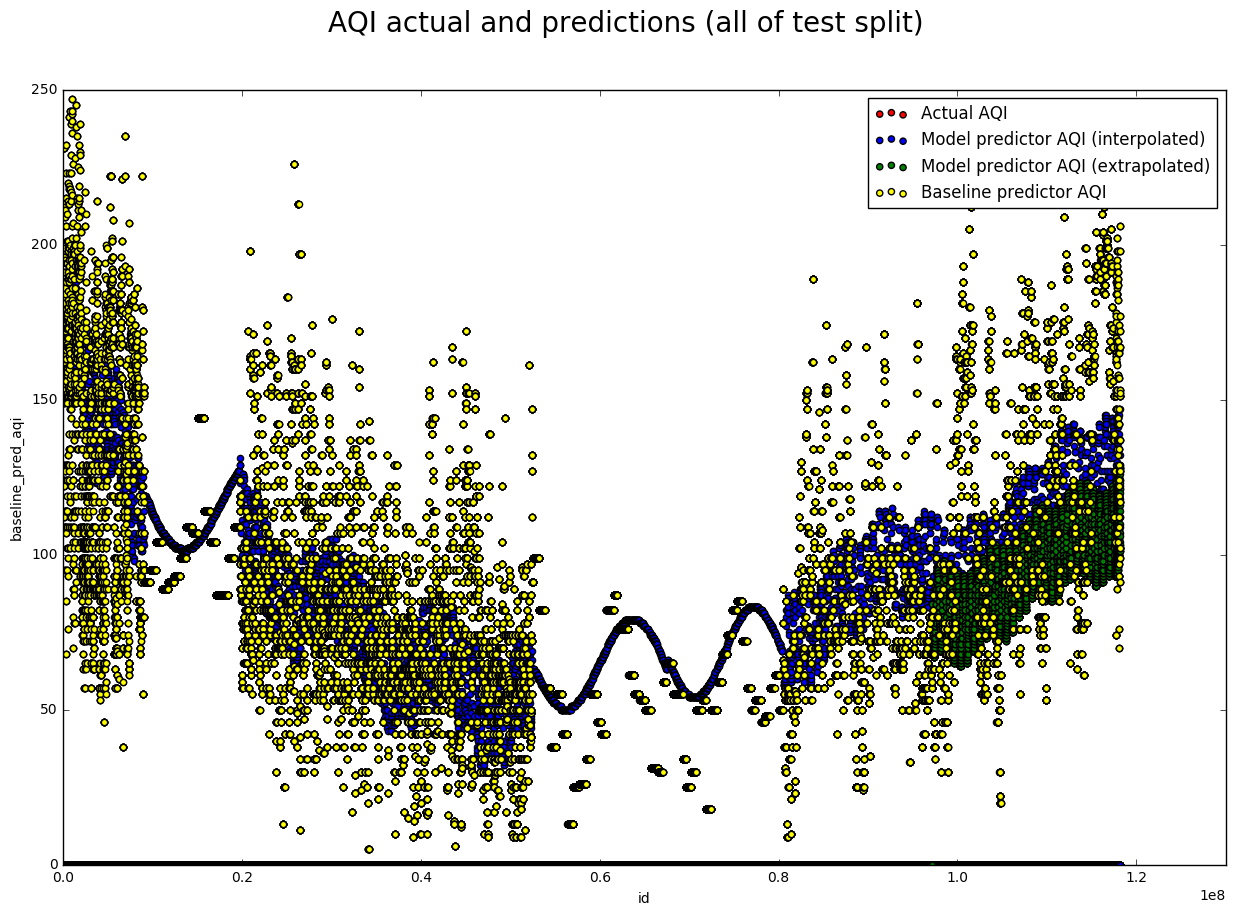

In [14]:
import matplotlib.pyplot as plt
aqi_graph = test_results.plot.scatter(x='id', y='aqi', label="Actual AQI", color="Red")
test_results.plot.scatter(x='id', y='pred_aqi_i', label="Model predictor AQI (interpolated)", ax=aqi_graph, color="Blue")
test_results.plot.scatter(x='id', y='pred_aqi_e', label="Model predictor AQI (extrapolated)", ax=aqi_graph, color="Green")
test_results.plot.scatter(x='id', y='baseline_pred_aqi', label="Baseline predictor AQI", ax=aqi_graph, color="Yellow")
fig = aqi_graph.figure
fig.set_size_inches((15, 10), forward=True)
fig.suptitle("AQI actual and predictions (all of test split)", fontsize=20)
aqi_graph.axis([0.0, 130000000.0, 0.0, 250.0])

[0.0, 130000000.0, 0.0, 150.0]

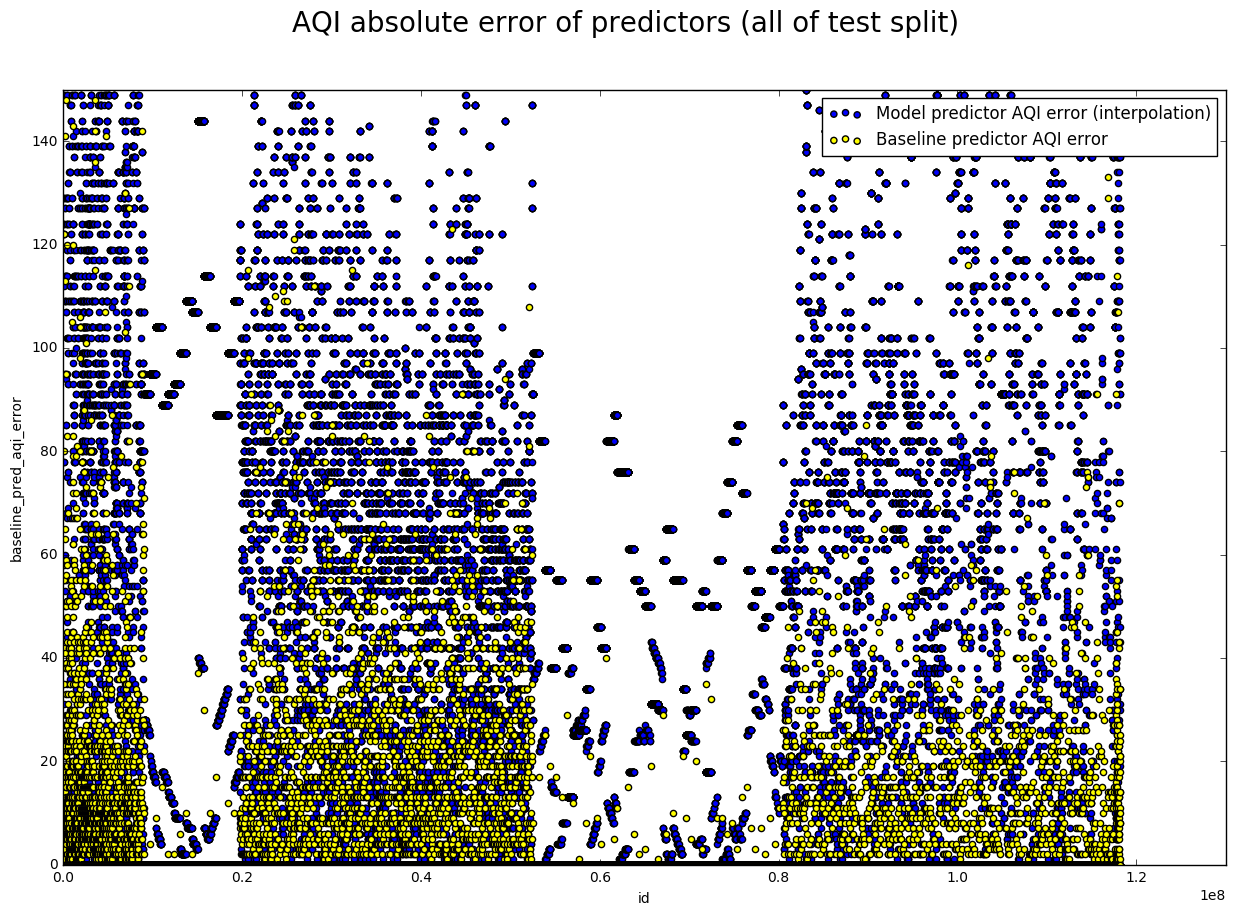

In [17]:
def absolute_error_generator(compare_col):
    def absolute_error(row):
        return abs(row[compare_col] - row['aqi'])
    return absolute_error

test_results['pred_aqi_error_i'] = test_results.apply(absolute_error_generator('pred_aqi_i'), 1)
#test_results['pred_aqi_error_e'] = test_results.apply(absolute_error_generator('pred_aqi_e'), 1)
test_results['baseline_pred_aqi_error'] = test_results.apply(absolute_error_generator('baseline_pred_aqi'), 1)

aqi_graph = test_results.plot.scatter(x='id', y='pred_aqi_error_i', label="Model predictor AQI error (interpolation)", color="Blue")
#test_results.plot.scatter(x='id', y='pred_aqi_error_e', label="Model predictor AQI error (extrapolation)", ax=aqi_graph, color="Green")
test_results.plot.scatter(x='id', y='baseline_pred_aqi_error', label="Baseline predictor AQI error", ax=aqi_graph, color="Yellow")
fig = aqi_graph.figure
fig.set_size_inches((15, 10), forward=True)
fig.suptitle("AQI absolute error of predictors (all of test split)", fontsize=20)
aqi_graph.axis([0.0, 130000000.0, 0.0, 150.0])

[100000000.0, 120000000.0, 0.0, 250.0]

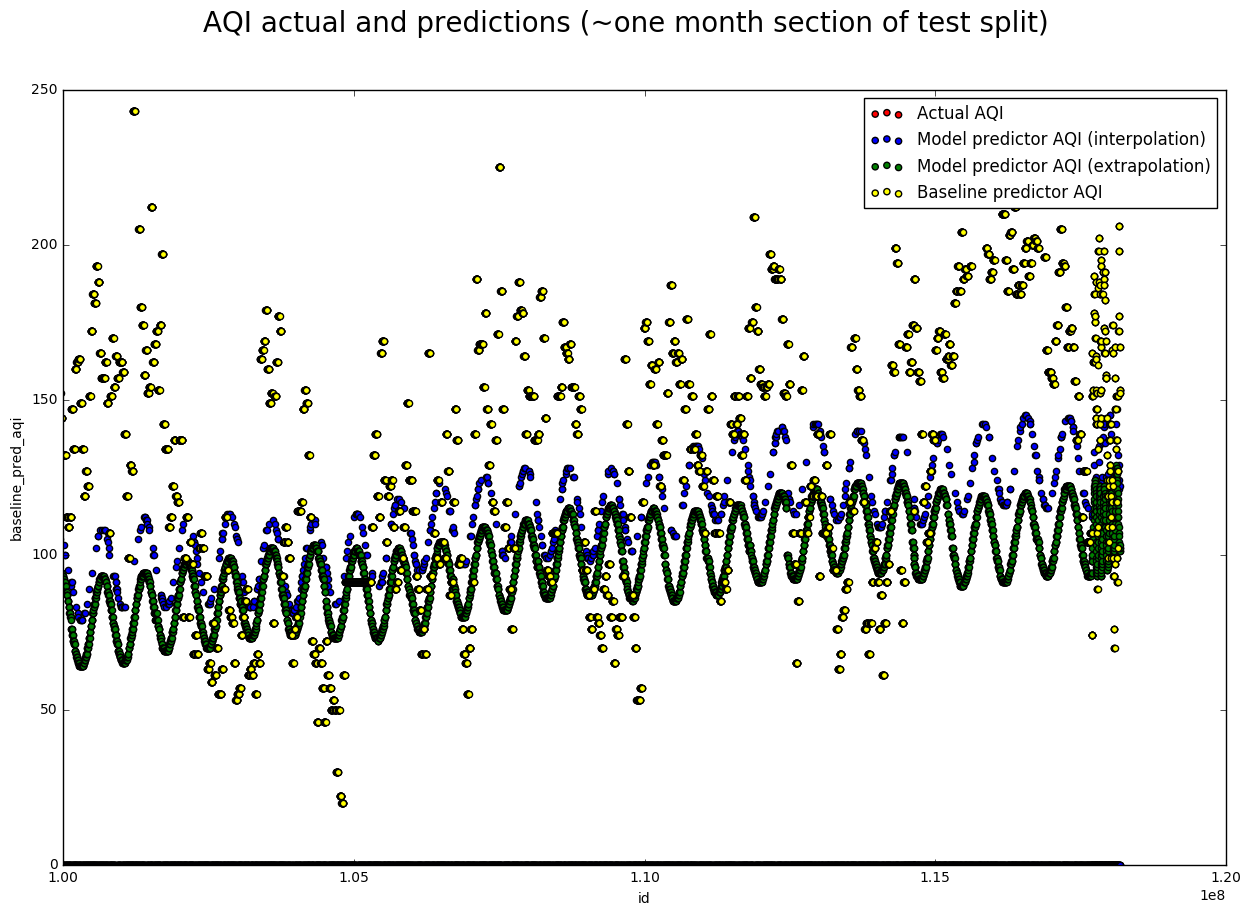

In [22]:
aqi_graph = test_results.plot.scatter(x='id', y='aqi', label="Actual AQI", color="Red")
test_results.plot.scatter(x='id', y='pred_aqi_i', label="Model predictor AQI (interpolation)", ax=aqi_graph, color="Blue")
test_results.plot.scatter(x='id', y='pred_aqi_e', label="Model predictor AQI (extrapolation)", ax=aqi_graph, color="Green")
test_results.plot.scatter(x='id', y='baseline_pred_aqi', label="Baseline predictor AQI", ax=aqi_graph, color="Yellow")
fig = aqi_graph.figure
fig.set_size_inches((15, 10), forward=True)
fig.suptitle("AQI actual and predictions (~one month section of test split)", fontsize=20)
aqi_graph.axis([100000000.0, 120000000.0, 0.0, 250.0])

[100000000.0, 103000000.0, 0.0, 250.0]

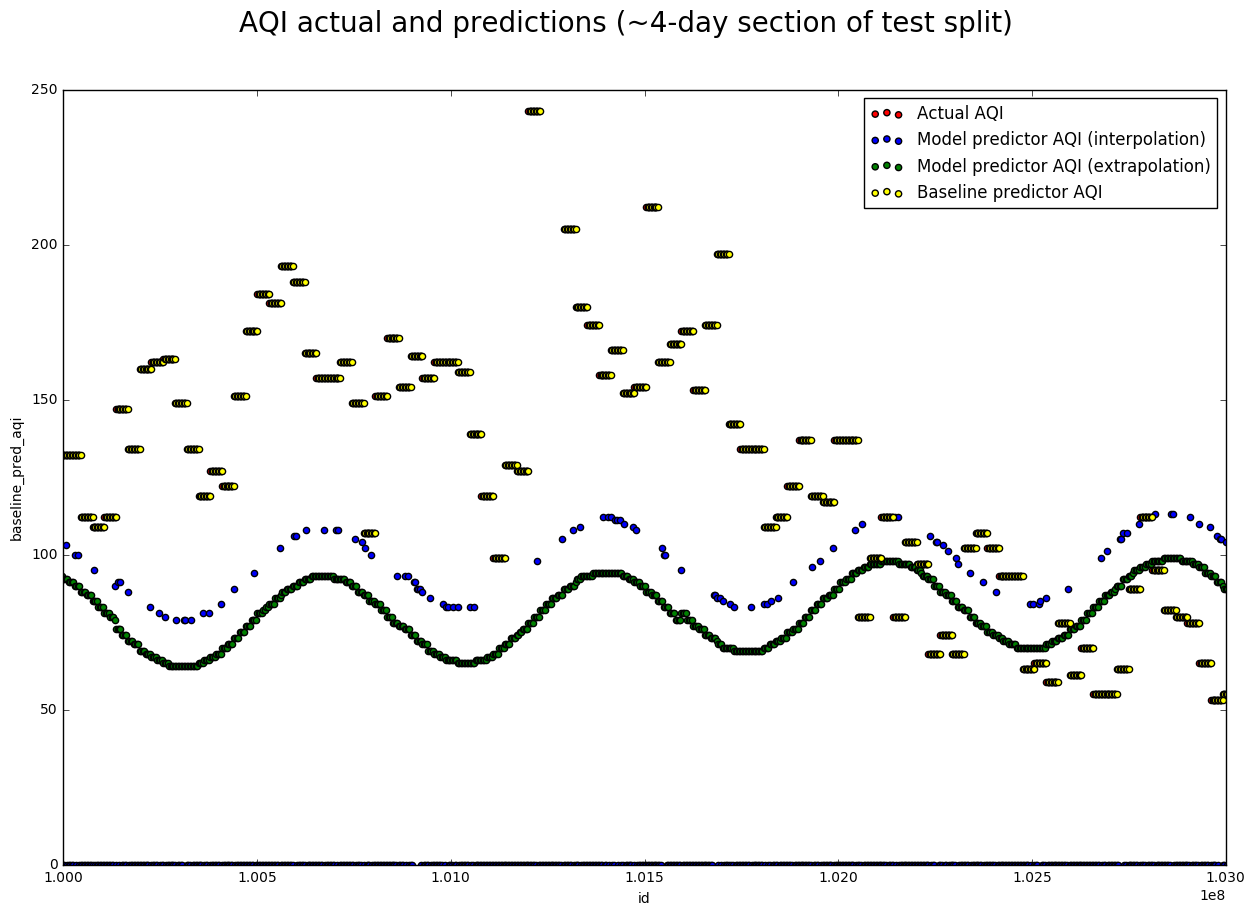

In [26]:
aqi_graph = test_results.plot.scatter(x='id', y='aqi', label="Actual AQI", color="Red")
test_results.plot.scatter(x='id', y='pred_aqi_i', label="Model predictor AQI (interpolation)", ax=aqi_graph, color="Blue")
test_results.plot.scatter(x='id', y='pred_aqi_e', label="Model predictor AQI (extrapolation)", ax=aqi_graph, color="Green")
test_results.plot.scatter(x='id', y='baseline_pred_aqi', label="Baseline predictor AQI", ax=aqi_graph, color="Yellow")
fig = aqi_graph.figure
fig.set_size_inches((15, 10), forward=True)
fig.suptitle("AQI actual and predictions (~4-day section of test split)", fontsize=20)
aqi_graph.axis([100000000.0, 103000000.0, 0.0, 250.0])